In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [48]:
dataset = './model/Point_History/Point/'
model_save_path = './model/Point_History/Point_His.hdf5'
tflite_save_path = './model/Point_History/Point_His.tflite'

In [49]:
NUM_CLASSES = 50
TIME_STEPS = 16
X_dataset = []
y_dataset = []

In [50]:
for i in range(NUM_CLASSES):
    data = pd.read_csv(dataset + str(i) + '.csv')
    r = data.iloc[:,1:].values
    t = []
    for row in r:
        if len(t) < TIME_STEPS * 44 * 2:
            t = np.append(t, row[:])
        else:
            X_dataset.append(t)
            y_dataset.append(i)
            t = []
            t = np.append(t, row[:])

X_dataset, y_dataset = np.array(X_dataset), np.array(y_dataset)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

In [52]:
use_lstm = False
model = None

if use_lstm:
    model = Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * 2 * 44, )),
        tf.keras.layers.Reshape((TIME_STEPS, 2 * 44), 
                                    input_shape=(TIME_STEPS * 2 * 44, )), 
        Dropout(0.3),
        LSTM(44, input_shape=[TIME_STEPS, 2 * 44]),
        Dropout(0.3),
        Dense(30, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * 2 * 44, )),
        Dropout(0.2),
        Dense(88, activation='relu'),
        Dropout(0.2),
        Dense(88, activation='relu'),
        Dropout(0.2),
        Dense(44, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])

In [53]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 1408)              0         
                                                                 
 dense_8 (Dense)             (None, 88)                123992    
                                                                 
 dropout_7 (Dropout)         (None, 88)                0         
                                                                 
 dense_9 (Dense)             (None, 88)                7832      
                                                                 
 dropout_8 (Dropout)         (None, 88)                0         
                                                                 
 dense_10 (Dense)            (None, 44)                3916      
                                                                 
 dense_11 (Dense)            (None, 50)               

In [54]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [55]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
19/24 [======================>.......] - ETA: 0s - loss: 3.8039 - accuracy: 0.0625
Epoch 1: saving model to ./model/Point_History\Point_His.hdf5
24/24 [==============================] - 2s 35ms/step - loss: 3.7720 - accuracy: 0.0711 - val_loss: 3.5420 - val_accuracy: 0.0866
Epoch 2/1000
23/24 [===========================>..] - ETA: 0s - loss: 3.3815 - accuracy: 0.1529
Epoch 2: saving model to ./model/Point_History\Point_His.hdf5
24/24 [==============================] - 1s 25ms/step - loss: 3.3815 - accuracy: 0.1528 - val_loss: 3.0684 - val_accuracy: 0.2003
Epoch 3/1000
18/24 [=====================>........] - ETA: 0s - loss: 3.0056 - accuracy: 0.2292
Epoch 3: saving model to ./model/Point_History\Point_His.hdf5
24/24 [==============================] - 0s 19ms/step - loss: 2.9462 - accuracy: 0.2381 - val_loss: 2.6029 - val_accuracy: 0.3018
Epoch 4/1000
21/24 [=========================>....] - ETA: 0s - loss: 2.5627 - accuracy: 0.2984
Epoch 4: saving model to ./model/Point_H

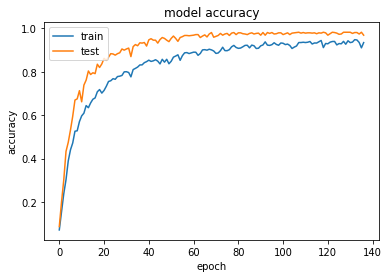

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

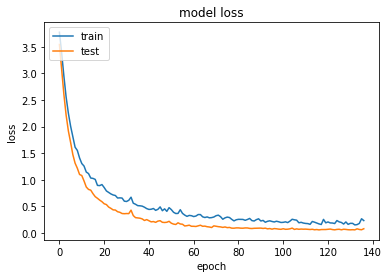

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [60]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

12/12 [==============================] - 0s 2ms/step - loss: 0.0811 - accuracy: 0.9689


In [61]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 68ms/step
[1.68272980e-18 4.43712896e-04 4.66460828e-04 4.29542069e-10
 2.01821429e-13 1.42877127e-10 4.47599399e-15 9.97986674e-01
 1.91577754e-09 3.71775907e-14 1.04419685e-11 1.60948754e-09
 1.68228643e-11 1.19376320e-09 1.24816043e-15 4.58983351e-07
 1.06882181e-09 4.36684716e-12 7.48813012e-09 5.07163993e-14
 1.03443007e-07 8.43754533e-05 2.04355421e-10 2.83027907e-06
 1.79431439e-17 4.13777818e-19 3.59643287e-11 5.91252308e-13
 1.11475629e-11 1.03677431e-08 1.42833323e-09 4.40864198e-08
 1.83374569e-14 6.29157781e-10 5.64628635e-07 2.76687034e-10
 1.98662207e-07 3.62894263e-11 8.78249994e-04 1.04770574e-08
 5.05415210e-10 1.82464349e-10 2.08484096e-07 2.63229188e-10
 2.96589942e-14 1.18090915e-09 4.51117048e-05 1.80172357e-08
 2.85833661e-12 9.09601367e-05]
7


# Confusion matrix

24/24 [==============================] - 0s 2ms/step


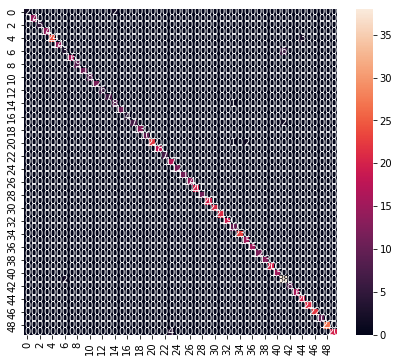

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        14
           4       1.00      0.89      0.94        27
           5       1.00      1.00      1.00        14
           6       0.60      0.33      0.43         9
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00        11
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         7
          14       0.80      0.89      0.84         9
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00         4
     

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [63]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [64]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\LETUAN~1\AppData\Local\Temp\tmppdu5qxsv\assets


INFO:tensorflow:Assets written to: C:\Users\LETUAN~1\AppData\Local\Temp\tmppdu5qxsv\assets


141488

In [65]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [66]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([   1, 1408]), 'shape_signature': array([  -1, 1408]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [67]:
interpreter.set_tensor(input_details[0]['index'], np.float32(np.array([X_test[0]])))

In [68]:
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [69]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.07450528e-18 5.71138458e-04 7.45608646e-04 5.10651965e-10
 2.92887947e-13 1.91355737e-10 6.62494411e-15 9.97195840e-01
 2.37470821e-09 4.51633089e-14 1.49827945e-11 2.34656294e-09
 2.36796190e-11 1.49510082e-09 1.57400639e-15 6.17073738e-07
 1.41039658e-09 6.73490604e-12 9.79541603e-09 7.09590874e-14
 1.32705665e-07 1.17985466e-04 3.19098636e-10 3.82075359e-06
 2.25333346e-17 5.68175525e-19 4.68931144e-11 8.32284220e-13
 1.59000781e-11 1.33224356e-08 1.87192462e-09 5.84343667e-08
 2.16182815e-14 7.61309016e-10 7.27605936e-07 3.49192203e-10
 2.34478023e-07 4.45300706e-11 1.16779783e-03 1.14230083e-08
 5.93497584e-10 2.48390059e-10 2.94928213e-07 3.34836270e-10
 3.63756029e-14 1.22260968e-09 6.10436837e-05 2.33239223e-08
 3.81305057e-12 1.34754169e-04]
7
